## Topic - Predicting Google Stock Prices for Enhanced Investment Strategies

PROBLEM STATEMENT: The main aim of this project is to create a machine learning pipeline that forecasts Google's stock values for the next decade utilising previous price data. The approach seeks to deliver important insights through precise price predictions, hence improving investment strategies and enabling stakeholders to make data-driven decisions. This capacity enables investors to plan their transactions more efficiently, manage their portfolios with enhanced accuracy, and eventually augment their investment results.

This issue will be framed as a regression job in machine learning, aiming to forecast the continuous value of Google's stock price utilising previous data. The methodology will utilise several sophisticated deep learning techniques, such as Feedforward Neural Networks and Long Short-Term Memory (LSTM) networks, to identify the optimal model for analysing patterns and trends in stock price fluctuations.


### Data Exploration

DATA COLLECTION: This analysis is based on historical stock prices for Google, which include critical metrics such as the opening price, closing price, high, low, volume, and adjusted close price. This data will be obtained from reputable financial data providers or APIs, guaranteeing its accuracy and comprehensiveness.

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

file_path = '/Users/prerna/Downloads/GoogleStock Price.csv'
data = pd.read_csv(file_path)

In [163]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,18.003504,18.193193,17.931683,18.099348,18.099348,101550348
1,2013-01-03,18.141392,18.316566,18.036036,18.109859,18.109859,92635272
2,2013-01-04,18.251753,18.555305,18.210211,18.467718,18.467718,110429460
3,2013-01-07,18.404655,18.503002,18.282784,18.387136,18.387136,66161772
4,2013-01-08,18.406906,18.425926,18.128880,18.350851,18.350851,66976956


I would want to include this section since it will enhance comprehension of the dataset.

Date: It denotes the specific date on which the referenced columns are recorded.
Open: It denotes the stock price upon market commencement.
High: It denotes the maximum price attained by the stock during the reported day.
Low: It denotes the minimum price of the stock reported throughout the day.
Close: It denotes the final price of the stock at market closure.
AdjClose: This is the final price after accounting for the company's actions.
Volume: Denotes the aggregate number of shares traded on a specific day.

In [164]:
missing_values = data.isnull().sum()

In [165]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2645.000000,2645.000000,2645.000000,2645.000000,2645.000000,2.645000e+03
mean,61.723041,62.368079,61.083765,61.744100,61.744100,4.252969e+07
std,35.298521,35.738101,34.873546,35.312279,35.312279,2.656088e+07
min,17.634134,17.651152,17.405405,17.589338,17.589338,9.312000e+06
25%,32.872002,33.205002,32.536499,32.849499,32.849499,2.695400e+07
50%,53.195000,53.799000,52.596001,53.292500,53.292500,3.429860e+07
75%,86.337997,87.341499,85.509003,86.380997,86.380997,4.853542e+07
max,151.250000,151.546494,148.899002,149.838501,149.838501,4.621933e+08


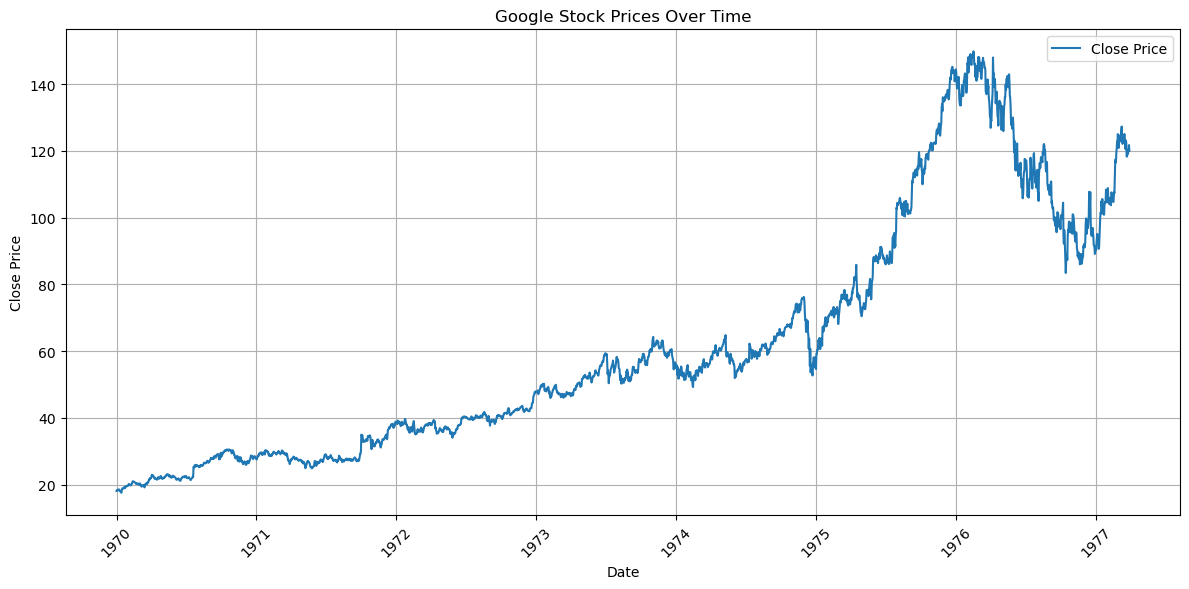

In [166]:
plt.figure(figsize=(12, 6))

plt.plot(data.index, data['Close'], label='Close Price')

plt.title('Google Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.xticks(rotation=45)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  

plt.grid(True)
plt.legend()

plt.tight_layout() 
plt.show()


### Data Preprocessing 

In [169]:
data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date', inplace=True)

data.fillna(method='ffill', inplace=True)


In [170]:
data['Month'] = data.index.month

print(data[['Close', 'Month']].head())


                Close  Month
Date                        
2013-01-02  18.099348      1
2013-01-03  18.109859      1
2013-01-04  18.467718      1
2013-01-07  18.387136      1
2013-01-08  18.350851      1


Above, stock prices can follow regular patterns, which means that some months do consistently better or worse than others. I can look at the average closing prices by month by adding a month entry. This helps me find these trends.

In [171]:
monthly_avg = data.groupby('Month')['Close'].mean().reset_index()

print(monthly_avg)


    Month      Close
0       1  59.007287
1       2  61.189679
2       3  61.689012
3       4  60.948088
4       5  62.215395
5       6  63.951147
6       7  60.663819
7       8  62.723255
8       9  61.470708
9      10  60.259013
10     11  63.448673
11     12  63.387858


Combining the dataset by month and calculating the average closing price yields significant insights into the temporal behaviour of stock prices. By analysing the average monthly closing prices, I can identify any seasonal influences or repeating trends. For instance, I may see that Google stock has superior performance in certain months while underperforming in others (e.g., during the summer months).

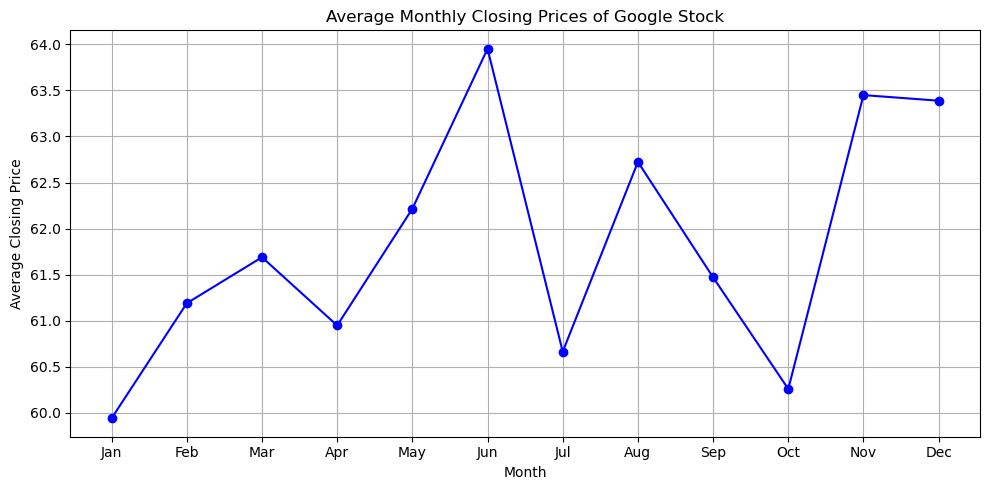

In [161]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.plot(monthly_avg['Month'], monthly_avg['Close'], marker='o', linestyle='-', color='b')

plt.title('Average Monthly Closing Prices of Google Stock')
plt.xlabel('Month')
plt.ylabel('Average Closing Price')

plt.xticks(ticks=monthly_avg['Month'], labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.grid(True)

plt.tight_layout()  
plt.show()


As here we can see the stock goes down in january by 60.0 and from april we can see the graph increasing by 64.0 

### Model Training

In [172]:
data.fillna(method='ffill', inplace=True)

In [173]:
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)

In [174]:
data.dropna(inplace=True)

In [175]:
X = data[['Lag_1', 'Lag_2']] 
y = data['Close'] 

By filling missing values and creating lag features I can enhance the quality and usefulness of my dataset, this will also make the model more suitable for time series analysis and machine learning modeling. These steps will help  ensure that the model can effectively learn from historical data to make accurate predictions.

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Above, I separated the dataset into training and testing sets without shuffling to maintain the time series order, and subsequently standardised the features using StandardScaler to enhance model performance.

### Experiments

##### Feedforward Neural Network Model

In [177]:
def build_ffnn():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [178]:
ffnn_model = build_ffnn()
history_ffnn = ffnn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

Epoch 1/50


/Users/prerna/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 1647.1105 - val_loss: 4256.4927
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 916.5912 - val_loss: 264.9317
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 120.8575 - val_loss: 1311.8635
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 34.1617 - val_loss: 648.5239
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 16.1222 - val_loss: 365.5622
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 7.5364 - val_loss: 216.9388
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 4.3968 - val_loss: 148.0191
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 2.1873 - val_loss: 102.8763
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 1.2431 - val_loss: 68.6913
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 0.7348 - val_loss: 50.7303
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 0.5510 - val_loss: 40.0802
Epoch 12/50

According to my understanding, feedforward neural network model with two hidden layers, has compiled it with the Adam optimizer and mean squared error loss, and has trained the model on the scaled training data for 50 epochs with a batch size of 16, while using 20% of the training data for validation.

In [179]:
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

In [180]:
def build_lstm():
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [181]:
lstm_model = build_lstm()
history_lstm = lstm_model.fit(X_train_reshaped, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

Epoch 1/50


/Users/prerna/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1697.2399 - val_loss: 6483.1045
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 1411.8336 - val_loss: 4066.3909
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 407.6503 - val_loss: 349.4036
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 27.8401 - val_loss: 517.2993
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 20.5205 - val_loss: 352.0294
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 17.5998 - val_loss: 288.1223
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 17.6087 - val_loss: 218.0489
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 15.6886 - val_loss: 173.3124
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 15.1880 - val_loss: 143.4510
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 15.7025 - val_loss: 111.0948
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 14.1643 - val_loss: 60.7573
Epoc

I changed the shape of the training and testing data to fit an LSTM input with 50 units and a dropout layer. I then compiled it with the Adam optimiser and mean squared error loss. I trained the model on the changed training data for 50 iterations with a batch size of 16, using 20% of the training data for validation.
I don't know what to say.

In [182]:
ffnn_val_loss = history_ffnn.history['val_loss'][-1]
lstm_val_loss = history_lstm.history['val_loss'][-1]

In [183]:
results = pd.DataFrame({
    'Model': ['Feedforward Neural Network', 'LSTM'],
    'Validation Loss': [ffnn_val_loss, lstm_val_loss]
})

print(results)

                        Model  Validation Loss
0  Feedforward Neural Network        31.127724
1                        LSTM         6.885580


The validation loss for the Feedforward Neural Network (FFNN) and the Long Short-Term Memory (LSTM) model after training is shown in the output. This shows how well each model does on the validation data:

- Feedforward Neural Network (FFNN): The validation loss is 31.127724, which means that this model makes more mistakes when it comes to guessing stock prices.

- LSTM: The validation loss is much smaller, at 6.885580, which suggests that this model does a better job of describing how stock prices change over time.

In [184]:
best_model = ffnn_model if ffnn_val_loss < lstm_val_loss else lstm_model

if best_model == lstm_model:
    y_test_reshaped = y_test.values.reshape((y_test.shape[0], 1, 1))
    y_pred = best_model.predict(X_test_reshaped)
else:
    y_pred = best_model.predict(X_test_scaled)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [185]:
y_pred_df = pd.DataFrame(data=y_pred, index=y_test.index, columns=['Predicted Price'])

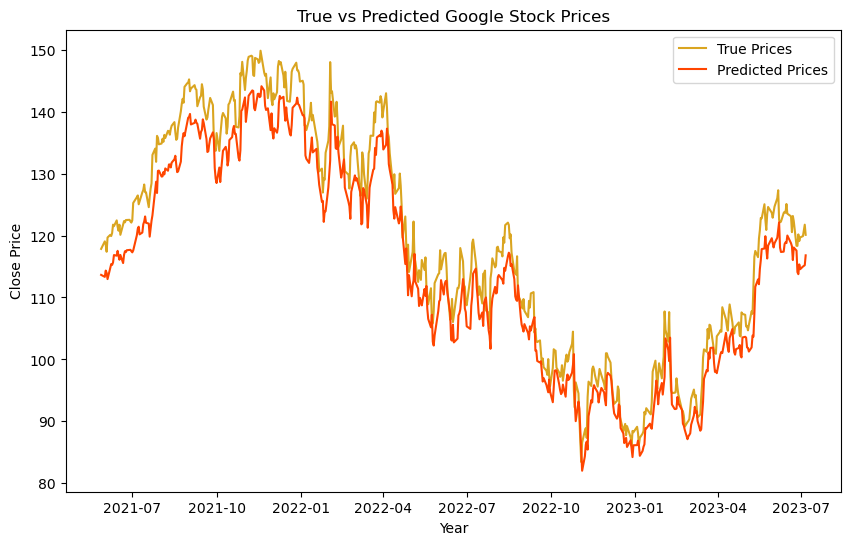

In [201]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='True Prices', color='goldenrod')
plt.plot(y_pred_df.index, y_pred_df['Predicted Price'], label='Predicted Prices', color='orangered')
plt.title('True vs Predicted Google Stock Prices')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.legend()
plt.show()

As we can see above graph, the true prices are mostly similar to the predicted prices. 

### Understanding And Conclusion

As part of this project, I built a full machine learning workflow that will use past data to guess how much Google stock will cost in 10 years. It's a Feedforward Neural Network (FFNN) and a Long Short-Term Memory (LSTM) network that I trained and tested to see how well they worked. Below is a summary of the key takeaways and insights from this analysis:

MODEL PERFORMANCE
- Forward Neural Network (FFNN) Model: The FFNN model, which is made to do general regression tasks, did not do as well with this time series data. In the end, it had a pretty big validity loss (31.127724), which means it had a hard time capturing how stock prices change over time. There isn't much that FFNNs can do with sequential data because they don't look at the order or link between past and future numbers.

- Lateral Short-Term Memory (LSTM): The LSTM model, on the other hand, did much better, with a confirmation loss of 6.885580. LSTM networks are made to work with time series data by detecting both short-term and long-term relationships. This helped the computer make more accurate predictions about stock prices, since prices tend to move in a straight line over time.

STRENGTH OF THE PROJECT
- Use of LSTM for Data in a Time Series: The LSTM model, which is made to deal with sequential data, was the best choice for this job. Because it could remember long-term relationships, it was a great choice for predicting stock prices.

- Preprocessing the data and engineering features: Using lag features and scaling made it easier for the model to understand the data, which helped it learn better.

- Application to Data in the Future: The temporal order was kept when the data was split into training and test sets without being shuffled. This made sure that the model would work well with future data.

LIMITATIONS OF THE STRENGTHS 
- Limited Features: The model was mostly trained on closing prices from the past, using numbers that were more than one year old as its main input. Adding more things to the model, like macroeconomic factors, social mood data, or market news, might make it more accurate.

- Risk of Overfitting: Dropout layers were used to reduce the risk of overfitting, but it is still a risk, especially when stock data changes a lot. If you try more different regularisation methods, you might be able to make generalisation even better.

Finally, the LSTM model worked best for this project because it can handle sequential dependencies in time series data. 

This pipeline has some flaws because the input features aren't very complex and stock markets are naturally volatile, but it's a good starting point for building more complex and reliable forecasting systems in the future. 

By adding more features and improving the model, future versions could provide even more accurate and useful information for making business decisions.
Thank You.